In [23]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker

import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import pickle
import json

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import ctables, USCOUNTIES,current_weather, sky_cover, StationPlot
from metpy.io import metar
from metpy.calc import reduce_point_density,wind_components

import zarr
import s3fs
import dataclasses
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import numcodecs as ncd

enDash = u'\u2013'

In [24]:
### import the appropriate plotting function in the "functions" folder
sys.path.insert(0, '/Users/rschumac/research/real_time/functions_rtwx')
from hrrr_aws_functions import *
#from hrrr_plots_sfc import *

In [25]:
#init_hour = int(sys.argv[1])
#station_lat = float(sys.argv[2])
#station_lon = float(sys.argv[3])
#station_name = sys.argv[4]

hrrr_init = pd.Timestamp(2022,12,21,23)

#init_hour = 21
station_lat = 39.739
station_lon = -104.9848
station_name = "cozoom"

print(hrrr_init)



2022-12-21 23:00:00


In [26]:
# Set projection

projection = ccrs.LambertConformal(central_longitude=262.5,
                                   central_latitude=38.5,
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

fs = s3fs.S3FileSystem(anon=True)
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))

# Don't recreate this resource in a loop! That caused a 3-4x slowdown for me.
s3 = boto3.resource(service_name='s3', region_name='us-west-1', config=Config(signature_version=UNSIGNED))


In [27]:
### set up bounding box surrounding specified station
latmin = station_lat - 3.
latmax = station_lat + 3.
lonmin = station_lon - 4.5
lonmax = station_lon + 4.5
#lonmin = -110.5
#lonmax = -100.5
#latmin = 36.
#latmax = 42.

### define a couple functions
def check_boundaries(data):
    return (latmin < data.latitude) & (data.latitude < latmax) & (
        lonmin < data.longitude) & (data.longitude < lonmax)

area = chunk_index.where(check_boundaries, drop=True)

def get_unique(data):
    # We have to implement our own "unique" logic since missing values are NaN (a float) and the rest are string
    data = data.fillna(None).values.flatten()
    data = data[data != None]
    return np.unique(data)

chunk_ids = get_unique(area.chunk_id)

init = hrrr_init

In [28]:
## define function that gets the appropriate chunks, subsets, and assigns the times
def process_variable_fcst(zarr_id):
    data_out = get_chunks_combined(zarr_id, chunk_ids, s3, chunk_index)
    data_out = data_out.where(check_boundaries,drop=True)
    data_out = data_out.assign_coords(time=("time", init + pd.to_timedelta(data_out.time.values+1, unit='H').values))

    return data_out

def process_variable_anl(zarr_id):
    data_out = get_chunks_combined(zarr_id, chunk_ids, s3, chunk_index)
    data_out = data_out.where(check_boundaries,drop=True)

    init_da = xr.DataArray([init])
    time_da = xr.DataArray(init_da, [('time', init_da.data)]).rename({'dim_0':'time'})
    #data_out = data_out.expand_dims({'time':time_da})
    data_out[zarr_id.var_name] = data_out[zarr_id.var_name].expand_dims({'time':time_da})

    return data_out

In [29]:
zarr_ids = {'t2m' : ZarrId(
                run_hour=hrrr_init,
                level_type="sfc",
                var_level="2m_above_ground",
                var_name="TMP",
                model_type="fcst"
                ),
           }

In [30]:
data_all_fcst = {}

print("getting forecast zarr")
for key, value in zarr_ids.items():
    print(key)
    data_all_fcst[key] = process_variable_fcst(value)

getting forecast zarr
t2m


In [31]:
zarr_ids_anl = {'t2m' : ZarrId(
                run_hour=hrrr_init,
                level_type="sfc",
                var_level="2m_above_ground",
                var_name="TMP",
                model_type="anl"
                ),
               }

In [32]:
data_all_anl = {}

print("getting analysis zarr")
for key, value in zarr_ids_anl.items():
    print(key)
    data_all_anl[key] = process_variable_anl(value)

getting analysis zarr
t2m


In [33]:
data_t2m = xr.merge([data_all_anl['t2m'],data_all_fcst['t2m']])
#* units("degK")

In [34]:
data_t2m

<xarray.Dataset>
Dimensions:     (x: 273, y: 242, time: 19)
Coordinates:
  * x           (x) float64 -1.063e+06 -1.06e+06 ... -2.495e+05 -2.465e+05
  * y           (y) float64 -1.893e+05 -1.863e+05 ... 5.307e+05 5.337e+05
  * time        (time) datetime64[ns] 2022-12-21T23:00:00 ... 2022-12-22T17:0...
Data variables:
    chunk_id    (x, y) object dask.array<chunksize=(130, 64), meta=np.ndarray>
    chunk_x     (x, y) float64 dask.array<chunksize=(130, 64), meta=np.ndarray>
    chunk_y     (y, x) float64 dask.array<chunksize=(64, 130), meta=np.ndarray>
    in_chunk_x  (x, y) float64 dask.array<chunksize=(130, 64), meta=np.ndarray>
    in_chunk_y  (y, x) float64 dask.array<chunksize=(64, 130), meta=np.ndarray>
    index_x     (x, y) float64 dask.array<chunksize=(130, 64), meta=np.ndarray>
    index_y     (y, x) float64 dask.array<chunksize=(64, 130), meta=np.ndarray>
    latitude    (y, x) float64 dask.array<chunksize=(64, 130), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(64, 130), meta=np.ndarray>
    TMP         (time, y, x) float16 dask.array<chunksize=(19, 64, 130), meta=np.ndarray>

In [35]:
print(latmin,latmax,lonmin,lonmax)

36.739 42.739 -109.4848 -100.4848


### now get surface obs

In [36]:
metar_in = metar.parse_metar_file("metar_"+init.strftime("%Y%m%d_%H%M")+".txt")

# Drop rows with missing winds
metar_in = metar_in.dropna(how='any', subset=['wind_direction', 'wind_speed'])

metar_in['coag'] = 0 ### add this column for use later

In [37]:
metar_in

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,wind_gust,visibility,current_wx1,...,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind,coag
station_id,,,,,,,,,,,,,,,,,,,,,
PTTP,PTTP,6.970000,158.220000,2.0,2023-12-21 22:57:00,70.0,4.0,NaN,20921.472,-SHRA,...,NaN,NaN,80,0,0,26.25 A2974,NaN,-3.758770,-1.368081e+00,0
KC62,KC62,41.470000,-85.270000,306.0,2023-12-21 22:55:00,120.0,5.0,NaN,11265.408,NaN,...,-2.0,30.28,0,0,0,AO2 T10111027,1027.84,-4.330127,2.500000e+00,0
KSUA,KSUA,27.180000,-80.220000,6.0,2023-12-21 22:47:00,350.0,10.0,NaN,11265.408,NaN,...,18.0,30.03,0,0,0,,1017.22,1.736482,-9.848078e+00,0
KJWN,KJWN,36.180000,-86.880000,151.0,2023-12-21 22:50:00,0.0,0.0,NaN,16093.440,NaN,...,-3.0,30.15,0,0,0,,1021.61,-0.000000,-0.000000e+00,0
KNQA,KNQA,35.350000,-89.870000,86.0,2023-12-21 22:50:00,0.0,0.0,NaN,16093.440,NaN,...,1.0,30.09,0,0,0,,1019.45,-0.000000,-0.000000e+00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KSVE,KSVE,40.360000,-120.570000,1263.0,2023-12-21 23:15:00,0.0,0.0,NaN,16093.440,NaN,...,2.0,30.21,0,0,0,AO2,1025.74,-0.000000,-0.000000e+00,0
KT69,KT69,28.033333,-97.550000,15.0,2023-12-21 23:15:00,0.0,0.0,NaN,16093.440,NaN,...,8.0,30.12,0,0,0,A01,1020.31,-0.000000,-0.000000e+00,0
CYEN,CYEN,49.220000,-102.970000,581.0,2023-12-21 23:16:00,300.0,20.0,NaN,2816.352,-SN,...,-31.0,30.35,71,0,0,SLP357,1040.27,17.320508,-1.000000e+01,0


### get coagmet data too

In [38]:
coag_in = pd.read_csv("https://coagmet.colostate.edu/data/5min.csv?headers=yes&from="+(init-pd.Timedelta(days=1)).strftime("%Y-%m-%d")+"&to="+(init+pd.Timedelta(days=1)).strftime("%Y-%m-%d")+"&flds=t,rh,dewpt,precip,windSpeed,windDir,gustSpeed,gustDir&units=m",
                       header=[0],skiprows=[1])
print("https://coagmet.colostate.edu/data/5min.csv?headers=yes&from="+init.strftime("%Y-%m-%d")+"&to="+(init+pd.Timedelta(days=1)).strftime("%Y-%m-%d")+"&flds=t,rh,dewpt,precip,windSpeed,windDir,gustSpeed,gustDir&units=m")

coag_in['Date and Time'] = pd.to_datetime(coag_in['Date and Time'])

## set -999 to nan
coag_in.replace(-999,np.nan,inplace=True)
coag_in = coag_in.dropna() ## get rid of the nan rows)
#coag_in.reset_index(inplace=True)

coag_in['Date and Time'] = coag_in['Date and Time'].dt.tz_localize("Etc/GMT+7").dt.tz_convert("UTC")

coag_this = coag_in.loc[coag_in['Date and Time']==init.tz_localize("UTC")]

### haxtun wind direction is bad; remove it
coag_this = coag_this[~(coag_this.Station=="hxt01")]


https://coagmet.colostate.edu/data/5min.csv?headers=yes&from=2022-12-21&to=2022-12-22&flds=t,rh,dewpt,precip,windSpeed,windDir,gustSpeed,gustDir&units=m


In [39]:
## and get metadata
coag_meta = pd.read_csv("https://coagmet.colostate.edu/data/metadata.csv?headers=yes")
#coag_meta = pd.read_csv("https://coagmet.colostate.edu/data/metadata.csv?headers=yes").reset_index()
coag_meta.columns = ['Station', 'Name', 'Location', 'Latitude (degN)', 'Longitude (degE)',
       'Elevation (ft)', 'Anemometer Height (m)', 'Active', 'Irrigation',
       'First Observation', 'Last Observation', 'Timestep (s)','Network']

## and merge them
data_coag = coag_this.merge(coag_meta, on='Station')

data_coag.columns = ['station_id','date_time','air_temperature','relative_humidity',
                     'dew_point_temperature','precip','wind_speed',
                 'wind_direction','gust_speed','gust_direction','name','location',
                 'latitude','longitude','elevation',
                'anemometer_height','active','irrigation','first_obs','last_obs',
                     'timestep','network']

### calculate u and v components
coag_u,coag_v = wind_components((data_coag['wind_speed'].values*units('m/s')),
                           data_coag['wind_direction'].values*units.degree)

data_coag['eastward_wind'] = coag_u 
data_coag['northward_wind'] = coag_v

data_coag.set_index('station_id',inplace=True, drop=False)
data_coag['coag'] = 1
data_coag

,station_id,date_time,air_temperature,relative_humidity,dew_point_temperature,precip,wind_speed,wind_direction,gust_speed,gust_direction,...,anemometer_height,active,irrigation,first_obs,last_obs,timestep,network,eastward_wind,northward_wind,coag
station_id,,,,,,,,,,,,,,,,,,,,,
avn01,avn01,2022-12-21 23:00:00+00:00,11.13,0.167,-13.27,0.0,4.67,309.7,7.10,309.4,...,2,active,full,06/04/1992,12/12/2023,300,Coag,3.593096,-2.983046,1
bla01,bla01,2022-12-21 23:00:00+00:00,4.76,0.210,-15.76,0.0,5.70,251.0,7.62,245.8,...,2,active,dry,02/24/1997,12/12/2023,300,Coag,5.389456,1.855738,1
bnv01,bnv01,2022-12-21 23:00:00+00:00,-0.18,0.389,-12.52,0.0,5.59,244.7,8.37,237.0,...,2,active,part,10/12/2010,12/12/2023,300,Coag,5.053821,2.388930,1
brl02,brl02,2022-12-21 23:00:00+00:00,-6.98,0.727,-11.06,0.0,12.39,8.7,14.90,24.1,...,2,active,dry,01/02/1992,12/12/2023,300,Coag,-1.874122,-12.247439,1
brl03,brl03,2022-12-21 23:00:00+00:00,-10.22,0.757,-13.69,0.0,11.95,343.4,13.85,349.0,...,2,active,full,03/21/2008,12/12/2023,300,Coag,3.413976,-11.451955,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wfd01,wfd01,2022-12-21 23:00:00+00:00,-2.04,0.688,-7.00,0.0,4.74,184.3,6.88,122.8,...,2,active,dry,11/30/2004,12/12/2023,300,Coag,0.355399,4.726658,1
wls01,wls01,2022-12-21 23:00:00+00:00,10.80,0.199,-11.36,0.0,1.48,49.2,2.08,55.5,...,2,active,dry,04/11/2012,12/12/2023,300,Coag,-1.120353,-0.967062,1
wry02,wry02,2022-12-21 23:00:00+00:00,-18.77,0.709,-22.74,0.0,8.85,354.6,12.63,349.2,...,2,active,full,04/01/2015,12/12/2023,300,Coag,0.832859,-8.810723,1


In [40]:
sfc_all = pd.concat([metar_in,data_coag])

sfc_all

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,wind_gust,visibility,current_wx1,...,gust_direction,name,location,anemometer_height,active,irrigation,first_obs,last_obs,timestep,network
station_id,,,,,,,,,,,,,,,,,,,,,
PTTP,PTTP,6.97,158.22,2.0,2023-12-21 22:57:00,70.0,4.00,NaN,20921.472,-SHRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KC62,KC62,41.47,-85.27,306.0,2023-12-21 22:55:00,120.0,5.00,NaN,11265.408,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KSUA,KSUA,27.18,-80.22,6.0,2023-12-21 22:47:00,350.0,10.00,NaN,11265.408,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KJWN,KJWN,36.18,-86.88,151.0,2023-12-21 22:50:00,0.0,0.00,NaN,16093.440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KNQA,KNQA,35.35,-89.87,86.0,2023-12-21 22:50:00,0.0,0.00,NaN,16093.440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wfd01,wfd01,40.14,-106.40,7520.0,2022-12-21 23:00:00+00:00,184.3,4.74,NaN,NaN,NaN,...,122.8,Wolford Mtn Reservoir,5 mi NNW Kremmling,2.0,active,dry,11/30/2004,12/12/2023,300.0,Coag
wls01,wls01,37.38,-102.30,3974.0,2022-12-21 23:00:00+00:00,49.2,1.48,NaN,NaN,NaN,...,55.5,Walsh,"Plainsman Research Center in Walsh, CO",2.0,active,dry,04/11/2012,12/12/2023,300.0,Coag
wry02,wry02,40.22,-102.30,3736.0,2022-12-21 23:00:00+00:00,354.6,8.85,NaN,NaN,NaN,...,349.2,Wray 2,"Lenz Farm north of Wray, CO",2.0,active,full,04/01/2015,12/12/2023,300.0,Coag


In [41]:
# Set up the map projection
#proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
#                             standard_parallels=[35])
plotcrs = ccrs.LambertConformal(central_latitude=40, central_longitude=-105)

# Use the Cartopy map projection to transform station locations to the map and
# then refine the number of stations plotted by setting a 150km radius
point_locs = plotcrs.transform_points(ccrs.PlateCarree(), sfc_all['longitude'].values,
                                   sfc_all['latitude'].values)
sfc_thin = sfc_all[reduce_point_density(point_locs, 15000.)]

### now get the plot ready

In [42]:
### temperature contour levels & color scale
#clevs = np.arange(-40,110,2)  ### range of temperatures
clevs = np.arange(-40, 43, 1)

#### read in colormap
#fp = open('/Users/rschumac/research/real_time/functions_rtwx/sfc_temp_cmap.pkl', 'rb')
fp = open('sfc_temp_cmap.pkl', 'rb')
sfc_temp_cmap = pickle.load(fp)
fp.close()

/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


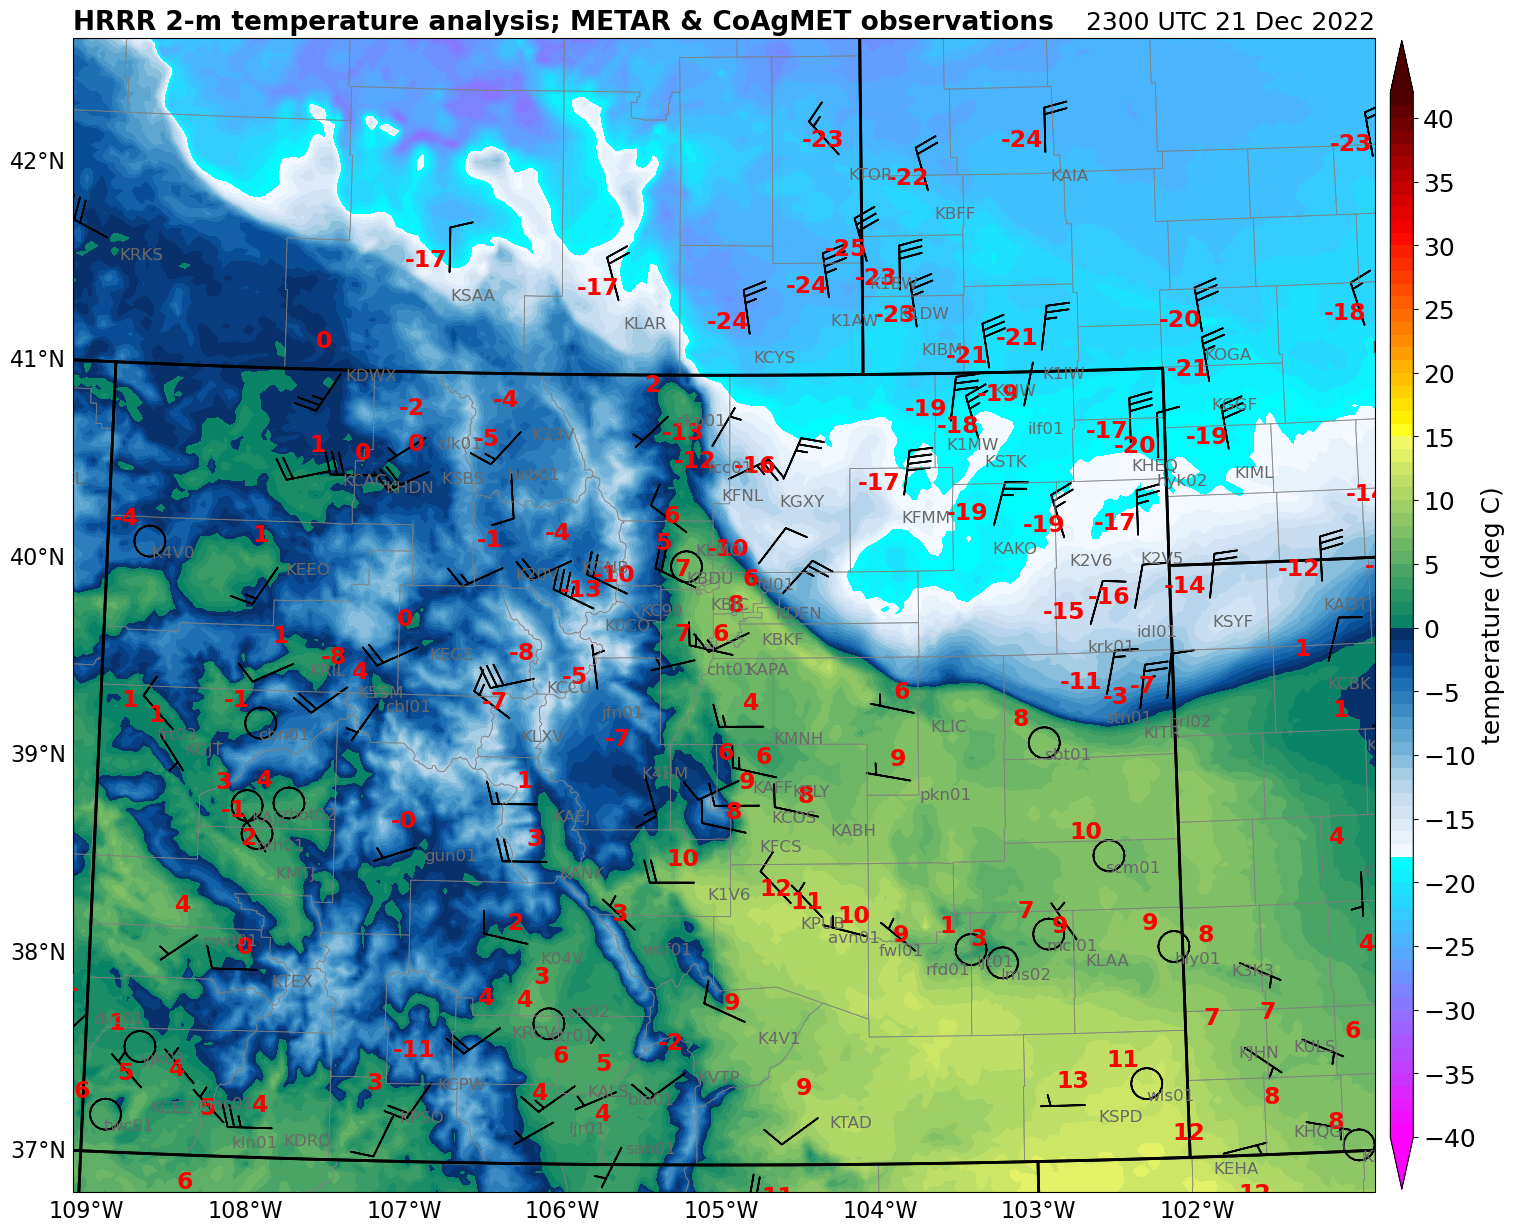

In [43]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.6,alpha=0.75)
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)

# Set plot bounds
#ax.set_extent((-118, -73, 23, 50))
#ax.set_extent((-108,-73, 23, 50))
#ax.set_extent([257.5,285.,25.,47.])
ax.set_extent([lonmin+0.4,lonmax-0.4,latmin+0.05,latmax-0.1])

### plot HRRR temperature analysis in background
cf = ax.contourf(data_t2m.longitude, data_t2m.latitude, 
                 data_t2m.TMP.sel(time=init)-273.12, ### for some reason this plot will not work when subtracting 273.15!!!
                 clevs,
                 cmap=sfc_temp_cmap, 
                 #alpha=0.7,
                 extend='both',
                 transform=ccrs.PlateCarree())
cb = plt.colorbar(cf, orientation='vertical', pad=0.01,
                  shrink=0.8, aspect=50)
cb.set_label('temperature (deg C)', fontsize=18)
cb.ax.locator_params(nbins=20)
cb.ax.tick_params(labelsize=18)

# Add the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',
                 x_inline=False, y_inline=False, rotate_labels=False)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator(np.arange(np.round(lonmin+0.4,0), np.round(lonmax-0.4,0), 1.0))
gl.ylocator = mticker.FixedLocator(np.arange(np.round(latmin+0.05,0), np.round(latmax-0.1,0), 1.0))
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.ylabel_style = {'size': 16, 'color': 'black'}
gl.xlabel_style = {'size': 16, 'color': 'black'}

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, sfc_thin['longitude'].values, sfc_thin['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=17)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', sfc_thin['air_temperature'].values, color='red',
                          fontweight='semibold')
#stationplot.plot_parameter('SW', sfc_thin['dew_point_temperature'].values,
#                           color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
#stationplot.plot_parameter('NE', sfc_thin['air_pressure_at_sea_level'].values,
#                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
#stationplot.plot_symbol('C', sfc_thin['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
#stationplot.plot_symbol('W', sfc_thin['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(sfc_thin['eastward_wind'].values, sfc_thin['northward_wind'].values,
                     length=8, lw=1.25)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
stationplot.plot_text((1., -0.5), sfc_thin['station_id'].values, fontsize=12, color='dimgray')

plt.title("HRRR 2-m temperature analysis; METAR & CoAgMET observations", loc='left', fontsize=19,
         fontweight='semibold')
plt.title(init.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=18)


### if you want to save your file, use code like this (you can use a better filename if you like)
fig.savefig("hrrr_t2m_sfcobs_"+init.strftime("%Y%m%d_%H%M")+".png", 
            bbox_inches='tight', facecolor='white', transparent=False, dpi=255)

plt.show()
plt.close('all')